In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import KFold

sns.set_style('ticks', {'axes.grid': False})
sns.set_context("paper", font_scale=1.2, rc={'lines.markersize': 8})

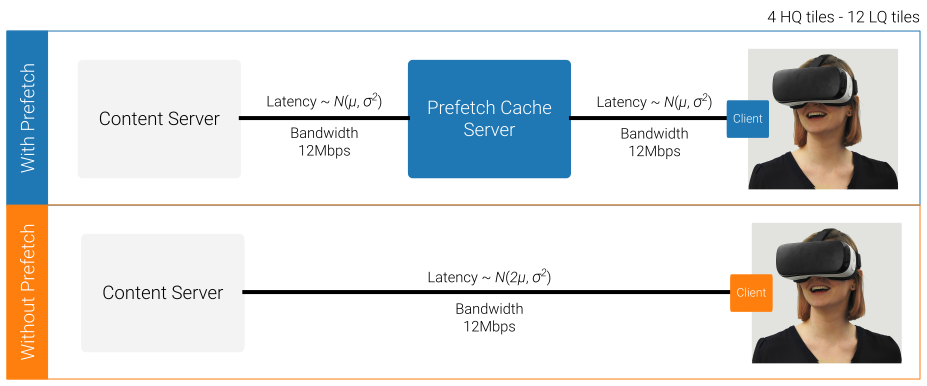

In [2]:
from IPython.display import SVG, display
display(SVG('../Explora-VR-RespTime-Setup.svg'))

In [3]:
folds = 8
indexes = list(range(48))
kf = KFold(n_splits=folds, shuffle=True, random_state=42)
kf.get_n_splits(indexes)

FOLD_DICT = {k+1: list(v[1]+1) for k, v in enumerate(list(kf.split(indexes)))}

In [4]:
FOLD_DICT

{1: [25, 27, 28, 38, 41, 44],
 2: [4, 5, 9, 13, 20, 26],
 3: [7, 14, 18, 34, 40, 46],
 4: [10, 16, 17, 30, 33, 47],
 5: [1, 6, 12, 31, 32, 35],
 6: [2, 3, 22, 36, 37, 45],
 7: [11, 19, 23, 24, 42, 48],
 8: [8, 15, 21, 29, 39, 43]}

In [5]:
K = -1
LOGS_PATH_TMP = '../logs/logs_perfect_pred/k{K}_{variant}_th{threshold}'.format(K=K, variant='{variant}', threshold='{threshold}')
VIDEO_LIST = [0,2,4]
VIDEO_TITLES = ['Sandwich', 'Spotlight', 'Surf']
# USER_LIST = range
# QUALITIES = [1, 2, 3, 4, 5]
PREFETCH_FILE_TMPL = 'log_seg_u{user}_prefetch.txt'
NO_PREFETCH_FILE_TMPL = 'log_seg_u{user}_no_prefetch.txt'
VARIANTS = {'dyn_vp_cc': 'NCP', 'dyn_vp_hw': 'HWP', 'dyn_vp_sc': 'NSP'}
THRESHOLDS = [90]
SEG_DUR = 1.065

results_list = []
prefetch_flag = False

for var in VARIANTS:
    for th in THRESHOLDS:
        for v in VIDEO_LIST:
            for fold in FOLD_DICT:
                for u in FOLD_DICT[fold]:
                    for file_tmpl in [PREFETCH_FILE_TMPL, NO_PREFETCH_FILE_TMPL]:
                        prefetch_flag = not prefetch_flag
                        with open(f'{LOGS_PATH_TMP.format(variant=var, threshold=th)}/fold{fold}/{v}/{file_tmpl.format(user=u)}', 'r') as p_file:
                            p_times = [float(t.strip()) for t in p_file.readlines()]
                            p_df = pd.DataFrame(columns=['video', 'user', 'prefetch', 'seg_resp_time'])
                            p_df['seg_resp_time'] = p_times
                            p_df['segment'] = p_df.index + 1
                            p_df['video'] = v
                            p_df['user'] = u
                            p_df['prefetch'] = f'{VARIANTS[var]}' if prefetch_flag else 'NO_PREFETCH'
                            p_df['threshold'] = th
                            results_list.append(p_df)
                
results_df = pd.concat(results_list, ignore_index=True)

In [6]:
results_df

,video,user,prefetch,seg_resp_time,segment,threshold
0,0,25,NCP,0.368945,1,90
1,0,25,NCP,0.371067,2,90
2,0,25,NCP,0.643588,3,90
3,0,25,NCP,0.900468,4,90
4,0,25,NCP,0.637963,5,90
...,...,...,...,...,...,...
25909,4,43,NO_PREFETCH,1.880992,26,90
25910,4,43,NO_PREFETCH,1.685706,27,90
25911,4,43,NO_PREFETCH,1.793593,28,90
25912,4,43,NO_PREFETCH,1.814379,29,90


In [7]:
stats = pd.DataFrame(group.describe().rename(columns={'seg_resp_time': prefetch}).squeeze()
                         for prefetch, group in results_df[['prefetch', 'seg_resp_time']].groupby(['prefetch'])).T
# stats['change'] = stats.pct_change(axis='columns').iloc[:,-1:]
stats

,HWP,NCP,NO_PREFETCH,NSP
count,4319.000000,4319.000000,12957.000000,4319.000000
mean,1.045237,0.501435,1.749810,1.568463
std,0.261065,0.123985,0.325636,0.352982
min,0.562346,0.236625,1.045558,0.855377
25%,0.889615,0.418676,1.588453,1.370508
50%,1.054182,0.498030,1.791616,1.583277
75%,1.178842,0.568814,1.945381,1.751196
max,2.224103,1.015690,2.761932,3.119916


In [8]:
# k_unique = results_df['k'].unique().tolist()
v_unique = results_df['video'].unique().tolist()

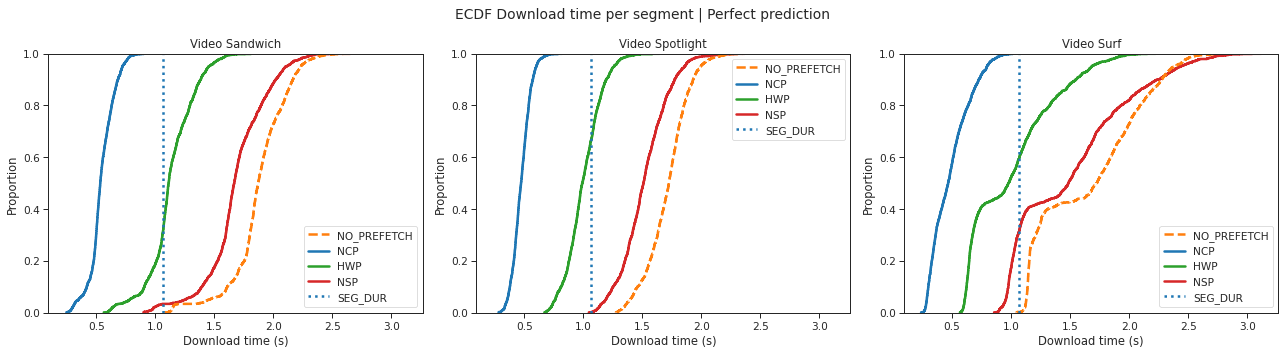

In [11]:
fig, axes = plt.subplots(len(THRESHOLDS), len(v_unique), figsize=(18,5), sharex=True)

for i in range(len(THRESHOLDS)):
    for j in range(len(v_unique)):
        axis = axes[i][j] if len(THRESHOLDS) > 1 else axes[j]
        sns.ecdfplot(
            data=results_df[(results_df['video'] == v_unique[j]) & (results_df['threshold'] == THRESHOLDS[i])], 
            x="seg_resp_time", 
            linewidth=2.5, 
            hue="prefetch",
            legend=True,
            ax=axis
        )

        axis.lines[2].set_linestyle("--")
        leg = axis.get_legend()
        leg_texts = [t.get_text() for t in leg.texts]
        leg.get_lines()[leg_texts.index('NO_PREFETCH')].set_linestyle("--")
        axis.set_title(f'Video {VIDEO_TITLES[j]}')
        axis.axvline(x=SEG_DUR, label='SEG_DUR', linewidth=2.5, linestyle=":")
#         axis.set_title(f'Video {j*2}')
        axis.set_xlabel('Download time (s)')
        axis.get_legend().set_title("")
        axis.legend(
            handles=[axis.lines[2], axis.lines[3], axis.lines[1], axis.lines[0], axis.lines[4]], 
            labels=["NO_PREFETCH", f"NCP", f"HWP", f"NSP", "SEG_DUR"]
        )    
        #     axis.set_xlim(0,2.5)
plt.suptitle(f'ECDF Download time per segment | Perfect prediction')
plt.tight_layout()

In [12]:
fig.savefig('ecdf-perfect-pred.pdf', format='pdf', dpi=300, bbox_inches='tight')

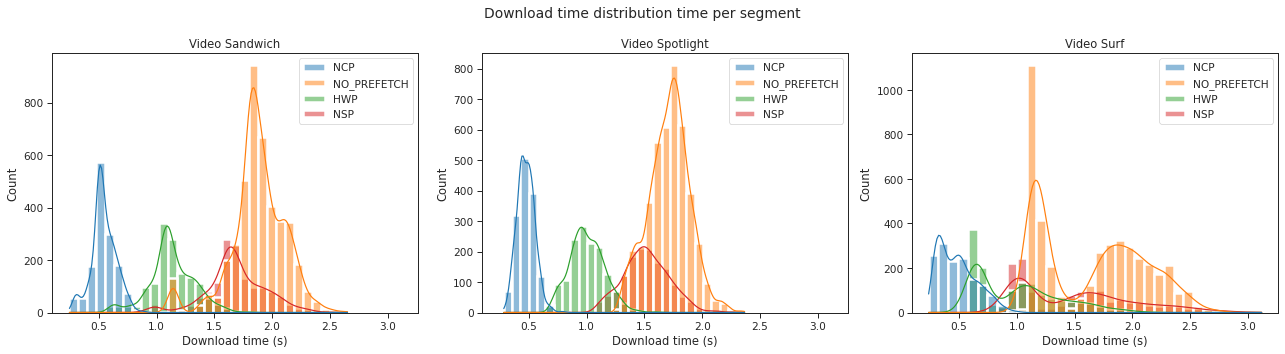

In [13]:
fig, axes = plt.subplots(len(THRESHOLDS), len(v_unique), figsize=(18,5), sharex=True)

for i in range(len(THRESHOLDS)):
    for j in range(len(v_unique)):
        axis = axes[i][j] if len(THRESHOLDS) > 1 else axes[j]
        sns.histplot(
            data=results_df[(results_df['video'] == v_unique[j]) & (results_df['threshold'] == THRESHOLDS[i])], 
            x="seg_resp_time", 
            linewidth=2.5, 
            hue="prefetch", 
            kde=True, 
            ax=axis
        )

        axis.set_title(f'Video {VIDEO_TITLES[j]}')
#         axis.set_title(f'Video {j*2}')
        axis.set_xlabel('Download time (s)')
        axis.get_legend().set_title("")
    #     axis.set_xlim(0,2.5)
plt.suptitle(f'Download time distribution time per segment')
plt.tight_layout()

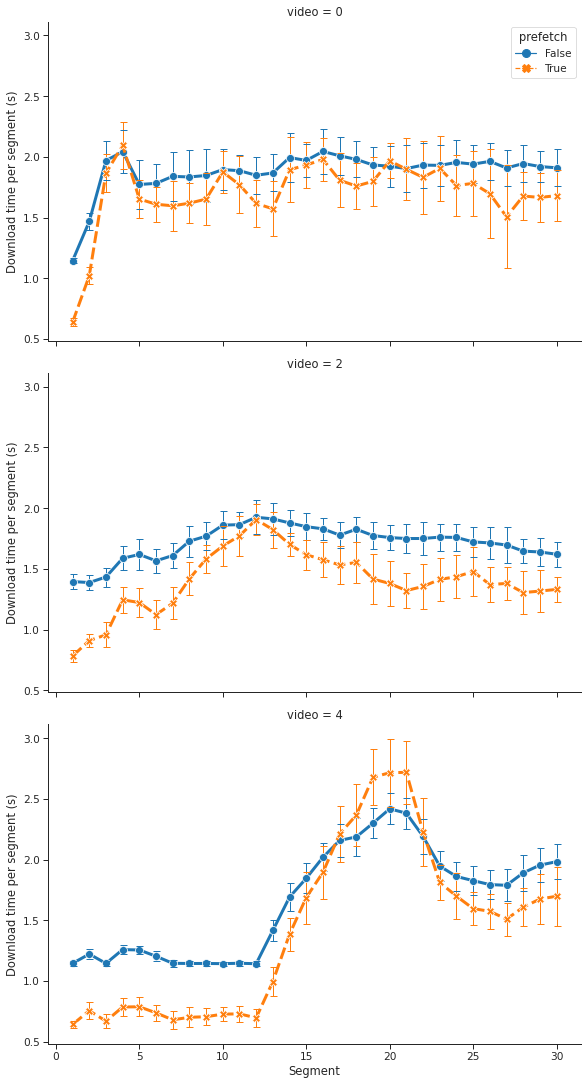

In [11]:
ax = sns.relplot(x="segment", 
                 y="seg_resp_time", 
                 hue="prefetch",
                 style='prefetch',
                 data=results_df, 
                 kind="line",
                 height=5, 
                 aspect=1.618,
                 row ="video",
                 err_style='bars', 
                 err_kws={"elinewidth": 1.0, "capsize": 3.5}, 
                 ci='sd', 
                 markers=True,
                 linewidth=3,
                 facet_kws = {'legend_out': False}
                )
ax.set_axis_labels("Segment", "Download time per segment (s)")#.set(ylim=(0, .5))